```{post} 2023-07-20
:author: Saul
```


```{eval-rst}
`Presentation as HTML <../2023_07_presentation.slides.html>`_
```


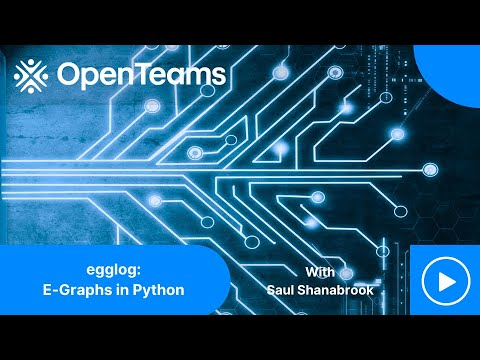

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("Pbi2uV9vWPg")

# EGraphs in Python

- Overview of the ecosystem
- What is an e-graph?
- What is egglog?
- What are some possible applications in the PyData world?


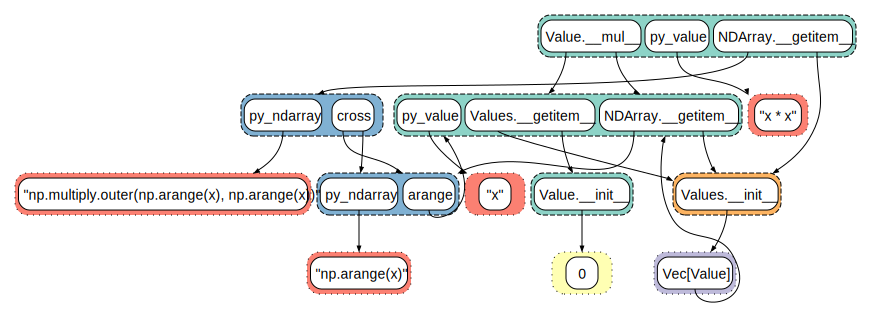

In [1]:
from IPython.display import SVG, display

with open("big_graph.svg") as f:
    display(SVG(f.read()))

<small>_Saul Shanabrook - July 20, 2023_</small>


## Open Source Data Science Ecosystem in Python

> <small>The term “ecosystem” is often used to describe the modern open-source scientific software. In biology, the term “ecosystem” is defined as a biological community of interacting organisms and their physical environment. Modern open-source scientific software development occurs in a similarly interconnected and interoperable fashion.</small>

<small>from [Jupyter Meets the Earth: Ecosystem](https://jupytearth.org/jupyter-resources/introduction/ecosystem.html)</small>

![](https://jupytearth.org/_images/python-stack.png)


### Aims

- How can the tools we build foster greater **resiliancy, collaboration, and interdependence** in this ecosystem?<br>
- How can they help it **stay flexible enough to adapt to the changing computational landscape** to empower users and authors?

### What role could `egglog` play?

- Bring the programming languages community closer to this space, providing theoretical frameworks for thinking about composition and language.
- Constrained type system could support decentralized interopability and composition between data science libraries.


### Other Python EGraph Libraries

- [`riswords/quiche`](https://github.com/riswords/quiche): Optimizing Python ASTs
- [`egraphs-good/snake-egg`](https://github.com/egraphs-good/snake-egg): Generic bindings for `egg`, can bring any Python objects as expressions.
- [EGraph library added to `ibis`](https://github.com/ibis-project/ibis/pull/5781): Conversions between dataframe syntax and SQL dialects


TODO: Put this first, Say it's for library authors

Semantics of python and egglog


- Started with `snake-egg`
- Didn't want to re-invent the wheel, stay abreast of recent developments and research
- Second piece that interests me
  - Unlike `egg` there are some builtin sorts, and can build user defined sorts on top of those
  - No host language conditions or data structures
  - Helps with optimization, more constrained
  - -> De-centers algorithms based on value, move to based on type. Everything becomes an interface.
  - Social dynamics, goal is ability to inovate and experiment, while still supporting existing use cases
    - New dataframe library comes out, supporting custom hardware. How dow we use it without rewriting code?
    - How do we have healthy ecosystem within these tools? Power
    - If it's too hard, encourages centralized monopolistic actors to step in provide one stop shop solutions for users.
  - Active problem in the community, with things like trying to standardize on interop.
  - Before getting too abstract, let's go to an example


## What is an e-graph?


> E-graphs are these super wonderful data structures for managing equality and equivalence information. They are traditionally used inside of constraint solvers and automated theorem provers to implement **congruence closure**, an efficient algorithm for equational reasoning---but they can also be used to implement **rewrite systems**.
>
> [Talia Ringer - "Proof Automation" course](https://dependenttyp.es/classes/readings/17-egraphs.html)


- Come from automated theorum proving world
- Something congruence, which is like how triangles are similar but not equal,
- Can be used for term rewriting


> In abstract algebra, a congruence relation (or simply congruence) is an equivalence relation on an algebraic structure (such as a group, ring, or vector space) that is compatible with the structure in the sense that **algebraic operations done with equivalent elements will yield equivalent elements**.
>
> [Wikipedia - Congruence relation](https://en.wikipedia.org/wiki/Congruence_relation)


- doing one thing on a set will be the same as doing it on another


### Congruence Closure


In [2]:
from __future__ import annotations

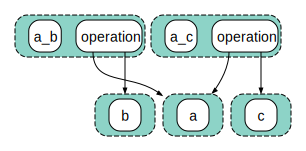

In [3]:
from egglog import *

egraph = EGraph()


@egraph.class_
class Structure(Expr): ...


a = egraph.constant("a", Structure)
b = egraph.constant("b", Structure)
c = egraph.constant("c", Structure)


@egraph.function
def operation(l: Structure, r: Structure) -> Structure: ...


a_b = egraph.let("a_b", operation(a, b))
a_c = egraph.let("a_c", operation(a, c))

egraph

- Define a structure, define an operation on that structure
- Define two elements
- Are they equal?


In [4]:
egraph.check(eq(a_b).to(a_c))

EggSmolError: Check failed: 
(= a_b a_c)

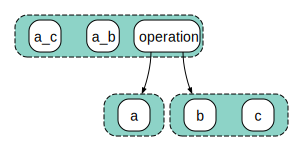

In [5]:
egraph.register(union(b).with_(c))
egraph.run(1)
egraph.check(eq(a_b).to(a_c))
egraph

We just used `egglog` to

- Define a structure
- Define some operation on that structure
- See it give us a congruence relation on that structure
  - "algebraic operations done with equivalent elements will yield equivalent elements"
  - We call a set of equivalent elements an **"e-class"** i.e. {a} or {b, c}
  - We only store pointers to other e-classes, not elements


- Combining elements... so that operations done on two elements of the same


### "Rewrite systems"?


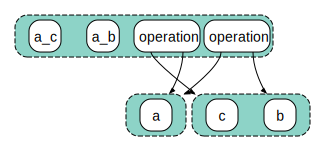

In [6]:
@egraph.register
def _operation_commutative(left: Structure, right: Structure):
    yield rewrite(operation(left, right)).to(operation(right, left))


egraph.run(run().saturate())
egraph.check(eq(operation(a, b)).to(operation(b, a)))
egraph

`egglog` can also be used for rewrite system:

- Define rules which will be matched on the e-graph
- The results will be added to the e-graph
- Can keep runnning these rules until the e-graph is "saturated"


In [7]:
@egraph.register
def _operation_identity(s: Structure):
    yield rewrite(operation(c, s)).to(c)


egraph.run(run().saturate())
egraph.extract(operation(c, a))

b

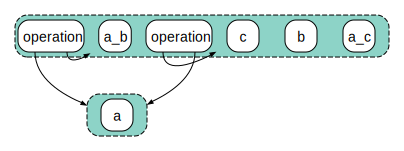

In [8]:
egraph

- Define `c` as the identity for this operation
- "extract" an expression to find lowest cost equivalent expression


What are e-graphs?

- Data structure to hold "congruence closure" i.e. sets of equivalent items
- Can implement term rewriting system on them
  - Order of rewrites don't matter b/c application only add information
  - Extract "best" expression from e-graph after applying rules


## What is `egglog`?


![](egg.png)


- Will show how some examples translate


### Sorts, expressions, and functions


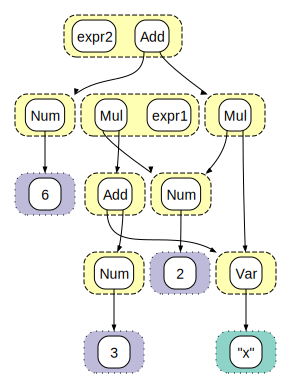

In [9]:
%%egglog graph
(datatype Math
  (Num i64)
  (Var String)
  (Add Math Math)
  (Mul Math Math))

(define expr1 (Mul (Num 2) (Add (Var "x") (Num 3))))
(define expr2 (Add (Num 6) (Mul (Num 2) (Var "x"))))


- User defined sorts
- Expressions
  - expr1 and expr2 in their own e-classes, we haven't ran any rules
- `%%egglog` magic, Writing egglog in Notebook, graphs, output inline.


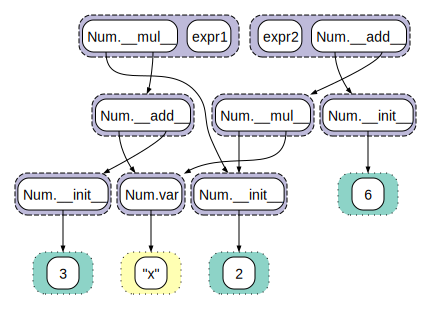

In [10]:
egraph = EGraph()


@egraph.class_
class Num(Expr):
    @classmethod
    def var(cls, name: StringLike) -> Num: ...

    def __init__(self, value: i64Like) -> None: ...

    def __add__(self, other: Num) -> Num: ...

    def __mul__(self, other: Num) -> Num: ...


expr1 = egraph.let("expr1", Num(2) * (Num.var("x") + Num(3)))
expr2 = egraph.let("expr2", Num(6) + Num(2) * Num.var("x"))
egraph

- Re-use existing Python class and functions
  - Humans and computers to understand the typing semantics
  - Humans read `__init__` and `__add__`.
  - Static type checkers. `Num("String")` it won't work.
  - Static type checking drives much of the API design of the library
- Operator overloading support infix operators
- Names generated based on classes
  - Same operator on different types compile to different function with different signature


### Rewrite rules and checks


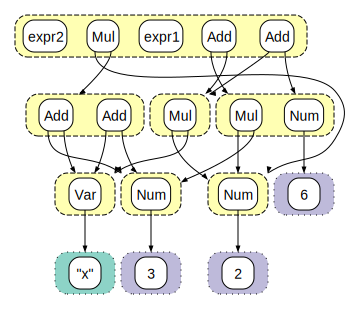

In [11]:
%%egglog graph continue
(rewrite (Add a b)
         (Add b a))
(rewrite (Mul a (Add b c))
         (Add (Mul a b) (Mul a c)))
(rewrite (Add (Num a) (Num b))
         (Num (+ a b)))
(rewrite (Mul (Num a) (Num b))
         (Num (* a b)))

(run 10)
(check (= expr1 expr2))


- See equivalent, in same e-class now


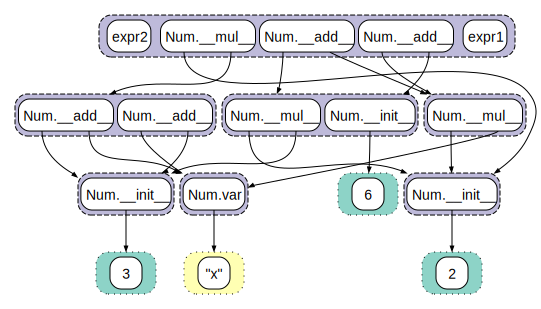

In [12]:
@egraph.register
def _(a: Num, b: Num, c: Num, i: i64, j: i64):
    yield rewrite(a + b).to(b + a)
    yield rewrite(a * (b + c)).to((a * b) + (a * c))
    yield rewrite(Num(i) + Num(j)).to(Num(i + j))
    yield rewrite(Num(i) * Num(j)).to(Num(i * j))


egraph.run(10)
egraph.check(eq(expr1).to(expr2))
egraph

- Similar in Python, rewrite rules, run, check
- Notice that all vars need types, unlike inferred in egglog
  - Both for static type checkers to verify
  - And for runtime to know what methods


### Extracting lowest cost expression


In [13]:
%%egglog continue output
(extract expr1)



Extracted with cost 8: (Mul (Num 2) (Add (Var "x") (Num 3)))


- Extract lowest cost expr


In [14]:
egraph.extract(expr1)

(Num(2) * Num.var("x")) + Num(6)

- get back expr object
- Str representation is Python syntax


### Multipart Rules


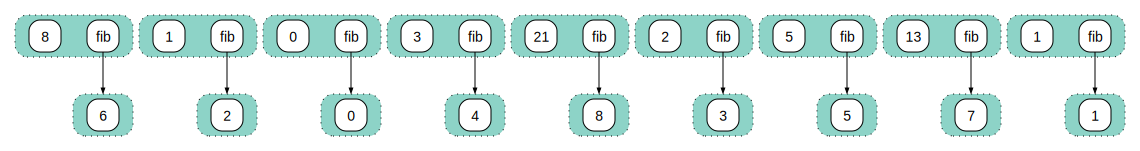

In [15]:
%%egglog graph
(function fib (i64) i64)

(set (fib 0) 0)
(set (fib 1) 1)
(rule ((= f0 (fib x))
       (= f1 (fib (+ x 1))))
      ((set (fib (+ x 2)) (+ f0 f1))))

(run 7)
(check (= (fib 7) 13))


- Rule that depend on facts and execute actions


In [16]:
fib_egraph = EGraph()


@fib_egraph.function
def fib(x: i64Like) -> i64: ...


@fib_egraph.register
def _(f0: i64, f1: i64, x: i64):
    yield set_(fib(0)).to(i64(1))
    yield set_(fib(1)).to(i64(1))
    yield rule(
        eq(f0).to(fib(x)),
        eq(f1).to(fib(x + 1)),
    ).then(set_(fib(x + 2)).to(f0 + f1))


fib_egraph.run(7)
fib_egraph.check(eq(fib(7)).to(i64(21)))

- `set_` and and `eq` both type safe. Required builder syntax


### Include & Modules


In [17]:
%%writefile path.egg
(relation path (i64 i64))
(relation edge (i64 i64))

(rule ((edge x y))
      ((path x y)))

(rule ((path x y) (edge y z))
      ((path x z)))


Overwriting path.egg


In [18]:
%%egglog
(include "path.egg")
(edge 1 2)
(edge 2 3)
(edge 3 4)
(run 3)
(check (path 1 3))


- Include another file for re-useability


In [19]:
mod = Module()
path = mod.relation("path", i64, i64)
edge = mod.relation("edge", i64, i64)


@mod.register
def _(x: i64, y: i64, z: i64):
    yield rule(edge(x, y)).then(path(x, y))
    yield rule(path(x, y), edge(y, z)).then(path(x, z))

- Modules same in Python
- Supports defining rules, etc, but doesn't actually run them, just builds up commands


In [20]:
egraph = EGraph([mod])
egraph.register(edge(1, 2), edge(2, 3), edge(3, 4))
egraph.run(3)
egraph.check(path(1, 3))

- Then when we depend on them, it will run those commands first.
- Allows distribution of code and others to re-use it, using existing Python import mechanisms.


### Python Objects

`egglog` supports `i64`, `f64`, `String`, `Vec`, `Map`, `Set`...

But what if I want to store a Python object in my e-graph?


In [61]:
egraph = EGraph()
res = egraph.save_object(True)
# Saves reference to object and stores in e-graph as type and value hashes:
res

PyObject(277923772, 1)

In [22]:
egraph.load_object(res)

True

Can eval arbitrary python code:


In [62]:
empty_dict = egraph.save_object({})
locals_ = empty_dict.dict_update(egraph.save_object("x"), res)

egraph.load_object(egraph.extract(py_eval("not x", locals_, empty_dict)))

### "Preserved" methods

...from egglog to Python...


In [24]:
egraph = EGraph()


@egraph.class_
class Bool(Expr):
    def to_py(self) -> PyObject: ...

    def __or__(self, other: Bool) -> Bool: ...

    # This will get executed eagerly
    @egraph.method(preserve=True)
    def __bool__(self) -> bool:
        print(self)
        egraph.register(self)
        egraph.run(run(limit=10).saturate())
        print(f"   -> {egraph.extract(self)}")
        return egraph.load_object(egraph.extract(self.to_py()))


TRUE = egraph.constant("TRUE", Bool)
FALSE = egraph.constant("FALSE", Bool)

In [25]:
bool(TRUE | FALSE)

TRUE | FALSE
   -> TRUE | FALSE


EggSmolError: Not found: fake expression Bool.to_py [Value { tag: "Bool", bits: 2 }]

In [26]:
@egraph.register
def _bool(x: Bool):
    return [
        set_(TRUE.to_py()).to(egraph.save_object(True)),
        set_(FALSE.to_py()).to(egraph.save_object(False)),
        rewrite(TRUE | x).to(TRUE),
        rewrite(FALSE | x).to(x),
    ]


bool(TRUE | FALSE)

TRUE | FALSE
   -> TRUE


True

In [27]:
x = egraph.constant("x", Bool)
if TRUE | x:
    print("it's true!")

TRUE | x
   -> TRUE
it's true!


### Conversions

...from Python to egglog...


In [28]:
converter(bool, Bool, lambda x: TRUE if x else FALSE)

TRUE | False

TRUE | FALSE

- Allow you to do "upcasting" which is very common in Python
- Can get closer to mimicking regular Python APIs


### Fib Example


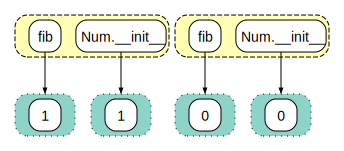

In [52]:
egraph = EGraph()


@egraph.class_
class Num(Expr):
    def __init__(self, i: i64Like) -> None: ...

    def __add__(self, other: Num) -> Num: ...


@egraph.function
def fib(x: i64Like) -> Num: ...


@egraph.register
def _fib(a: i64, b: i64, x: i64, f: Num):
    return [
        rewrite(Num(a) + Num(b)).to(Num(a + b)),
        rule(eq(f).to(fib(x)), x > 1).then(set_(fib(x)).to(fib(x - 1) + fib(x - 2))),
        set_(fib(0)).to(Num(0)),
        set_(fib(1)).to(Num(1)),
    ]


egraph

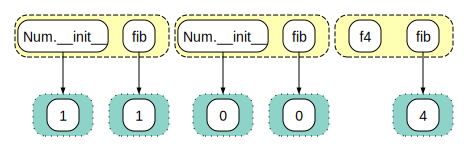

In [53]:
f4 = egraph.let("f4", fib(4))
egraph

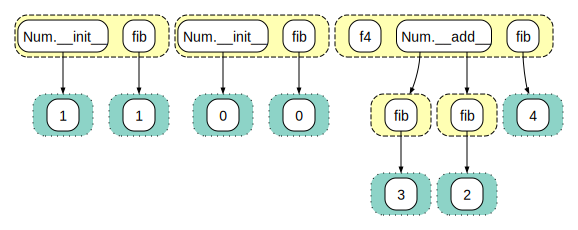

In [54]:
egraph.run(1)
egraph

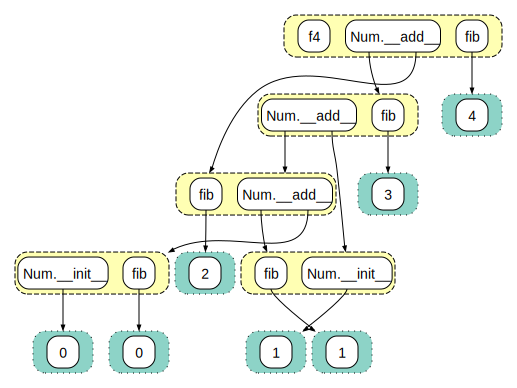

In [55]:
egraph.run(1)
egraph

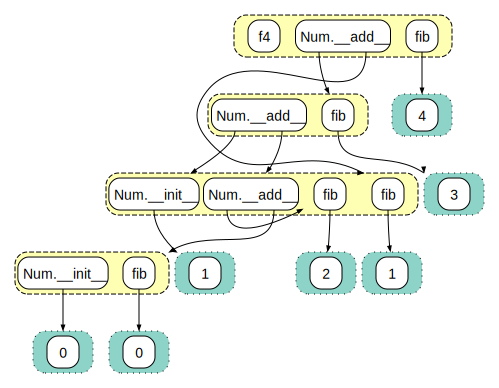

In [56]:
egraph.run(1)
egraph

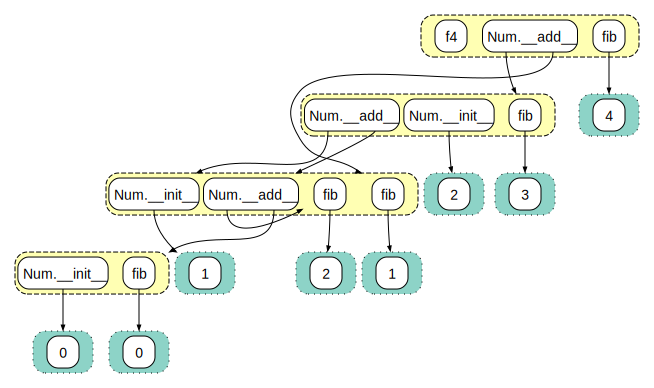

In [57]:
egraph.run(1)
egraph

Num(3)


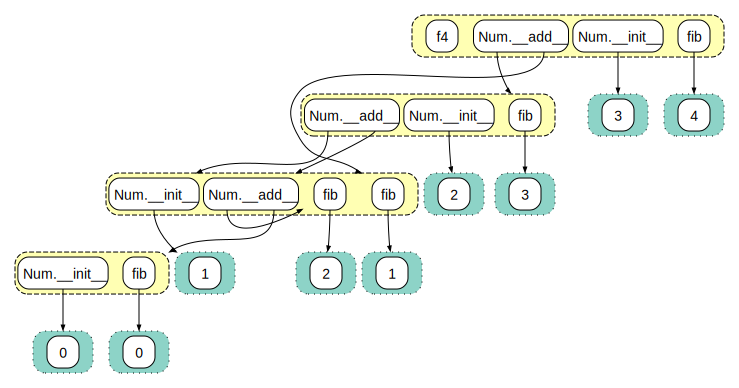

In [59]:
egraph.run(1)
print(egraph.extract(f4))
egraph

### A story about Arrays


- This is one path through a huge maze of use cases.
- Does not represent one killer example, but is an area I am familar with based on my previous work


#### 1. Someone makes an NDArray library...


In [29]:
ndarray_mod = Module()

In [30]:
@ndarray_mod.class_
class Value(Expr):
    def __init__(self, v: i64Like) -> None: ...

    def __mul__(self, other: Value) -> Value: ...

    def __add__(self, other: Value) -> Value: ...


i, j = vars_("i j", i64)
ndarray_mod.register(
    rewrite(Value(i) * Value(j)).to(Value(i * j)),
    rewrite(Value(i) + Value(j)).to(Value(i + j)),
)


@ndarray_mod.class_
class Values(Expr):
    def __init__(self, v: Vec[Value]) -> None: ...

    def __getitem__(self, idx: Value) -> Value: ...

    def length(self) -> Value: ...

    def concat(self, other: Values) -> Values: ...


@ndarray_mod.register
def _values(vs: Vec[Value], other: Vec[Value]):
    yield rewrite(Values(vs)[Value(i)]).to(vs[i])
    yield rewrite(Values(vs).length()).to(Value(vs.length()))
    yield rewrite(Values(vs).concat(Values(other))).to(Values(vs.append(other)))

In [31]:
@ndarray_mod.class_
class NDArray(Expr):
    def __getitem__(self, idx: Values) -> Value: ...

    def shape(self) -> Values: ...


@ndarray_mod.function
def arange(n: Value) -> NDArray: ...

- Basic
- One function, range, get shape and index into array
- Very different from existing paradigms in Python... Inheritance, multi-dispatch, dunder protocols.
  - Entirely open protocol.
  - Anyone else could define ways to create arrays
  - About mathematical definition really. This is from M


<small>Restifo Mullin, Lenore Marie, "A mathematics of arrays" (1988). _Electrical Engineering and Computer Science - Dissertations_. 249.</small>


In [32]:
@ndarray_mod.register
def _(n: Value, idx: Values, a: NDArray):
    yield rewrite(arange(n).shape()).to(Values(Vec(n)))
    yield rewrite(arange(n)[idx]).to(idx[Value(0)])

- Rules to compute shape and index into arange.


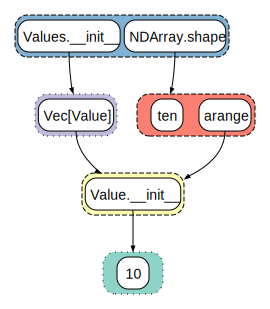

Values(Vec.empty().push(Value(10)))

In [33]:
egraph = EGraph([ndarray_mod])
ten = egraph.let("ten", arange(Value(10)))
ten_shape = ten.shape()
egraph.register(ten_shape)

egraph.run(20)
egraph.display()
egraph.extract(ten_shape)

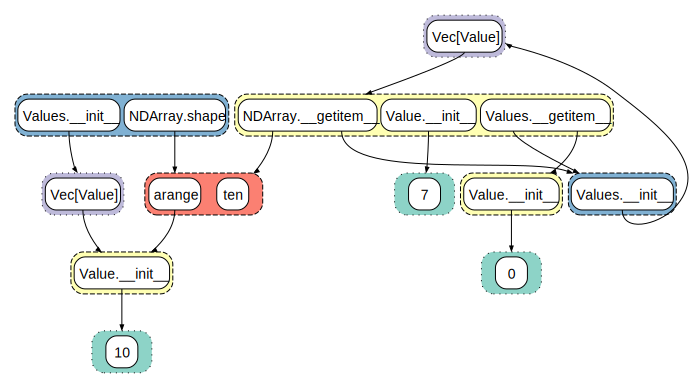

Value(7)

In [34]:
ten_indexed = ten[Values(Vec(Value(7)))]
egraph.register(ten_indexed)

egraph.run(20)

egraph.display()
egraph.extract(ten_indexed)

- Any user can try it now


#### 2. Someone else decides to implement a cross product library


In [35]:
cross_mod = Module([ndarray_mod])


@cross_mod.function
def cross(l: NDArray, r: NDArray) -> NDArray: ...


@cross_mod.register
def _cross(l: NDArray, r: NDArray, idx: Values):
    yield rewrite(cross(l, r).shape()).to(l.shape().concat(r.shape()))
    # Just noticed this is wrong!
    yield rewrite(cross(l, r)[idx]).to(l[idx] * r[idx])

- Someone decides to add some functionality
- Multiplicative cross product
- Shape is concatation, index is product of each matrix at that index
- Mathematical definition


In [36]:
egraph = EGraph([cross_mod])
egraph.simplify(cross(arange(Value(10)), arange(Value(11))).shape(), 10)

Values(Vec.empty().push(Value(11)).push(Value(10)))

#### 3. I write my wonderful data science application using it


In [37]:
def my_special_app(x: Value) -> Value:
    return cross(arange(x), arange(x))[Values(Vec(x))]


egraph = EGraph([cross_mod])

egraph.simplify(my_special_app(Value(10)), 10)

Value(100)

- Different person installs cross module
- Implements application using their complicated algorithm


.... but its too slow...


In [38]:
for i in range(100):
    egraph.simplify(my_special_app(Value(i)), 10)

- Too slow in inner loop
- Is there a way we could optimize it


#### 4. Someone else writes a library for delayed execution


In [39]:
py_mod = Module([ndarray_mod])


@py_mod.function
def py_value(s: StringLike) -> Value: ...

Ellipsis

- While this is happening, someone else, based on the original module, wrote a different execution semantics
- Builds up expression string instead of trying to evaluate eagerly


In [ ]:
@py_mod.register
def _py_value(l: String, r: String):
    yield rewrite(py_value(l) + py_value(r)).to(py_value(join(l, " + ", r)))
    yield rewrite(py_value(l) * py_value(r)).to(py_value(join(l, " * ", r)))


@py_mod.function
def py_values(s: StringLike) -> Values: ...


@py_mod.register
def _py_values(l: String, r: String):
    yield rewrite(py_values(l)[py_value(r)]).to(py_value(join(l, "[", r, "]")))
    yield rewrite(py_values(l).length()).to(py_value(join("len(", l, ")")))
    yield rewrite(py_values(l).concat(py_values(r))).to(py_values(join(l, " + ", r)))


@py_mod.function
def py_ndarray(s: StringLike) -> NDArray: ...


@py_mod.register
def _py_ndarray(l: String, r: String):
    yield rewrite(py_ndarray(l)[py_values(r)]).to(py_value(join(l, "[", r, "]")))
    yield rewrite(py_ndarray(l).shape()).to(py_values(join(l, ".shape")))
    yield rewrite(arange(py_value(l))).to(py_ndarray(join("np.arange(", l, ")")))

#### 5. I can use it jit compile my application!


In [41]:
egraph = EGraph([cross_mod, py_mod])
egraph.simplify(my_special_app(py_value("x")), 10)

py_value("x * x")

- I pull in third party library
- Add it to my e-graph
- Now I can compile lazily
- py_mod never needed to know about cross product, works with it


... and add support for jit compilation for the other library I am using, without changing either library:


In [42]:
@egraph.register
def _(l: String, r: String):
    yield rewrite(cross(py_ndarray(l), py_ndarray(r))).to(py_ndarray(join("np.multiply.outer(", l, ", ", r, ")")))

KeyError: "Callable ref FunctionRef(name='py_ndarray') not found"

In [ ]:
egraph.run(20)
egraph.graphviz().render(outfile="big_graph.svg", format="svg")

#### Takeaways...

_...from this totally realistic example._

- Declerative nature of `egglog` could facilitate decentralized library collaboration and experimentation.
  - Focus on types over values for library authors encourages interoperability.
- Pushing power down, empowering users and library authors
- Could allow greater collaboration between PL community and data science library community in Python


## Arrays in the "Real World"

What would it take to make this example work with `egglog`?


In [43]:
from sklearn import config_context, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target


def fit(X, y):
    with config_context(array_api_dispatch=True):
        lda = LinearDiscriminantAnalysis(n_components=2)
        return lda.fit(X, y).transform(X)


fit(X, y)[:5]

array([[ 8.06179978, -0.30042062],
       [ 7.12868772,  0.78666043],
       [ 7.48982797,  0.26538449],
       [ 6.81320057,  0.67063107],
       [ 8.13230933, -0.51446253]])

Could we execute this symbolically?

```python
@egraph.class_
class NDArray(Expr):
    @classmethod
    def var(cls, name: StringLike) -> NDArray:
        ...

    ...
X_arr = NDArray.var("X")
y_arr =  NDArray.var("y")
fit(X_arr, y_arr)
```

Started working on this yesterday...


Provide egglog with metadata at least about the types, to get through sklearn's sanity checks (which need to be executed eagerly):

```python
egraph.register(
    rewrite(X_arr.dtype).to(convert(X.dtype, DType)),
    rewrite(y_arr.dtype).to(convert(y.dtype, DType)),
    rewrite(isfinite(sum(X_arr)).bool()).to(TRUE),
    rewrite(isfinite(sum(y_arr)).bool()).to(TRUE),
    rewrite(X_arr.shape).to(convert(X.shape, TupleInt)),
    rewrite(y_arr.shape).to(convert(y.shape, TupleInt)),
    rewrite(X_arr.size).to(Int(X.size)),
    rewrite(y_arr.size).to(Int(y.size)),
    rewrite(unique_values(y_arr).shape).to(TupleInt(Int(3)))
)
```


Define all the required Array API functions:

```python
@egraph.function
def reshape(x: NDArray, shape: TupleInt, copy: OptionalBool = OptionalBool.none) -> NDArray:
    ...
```


```python
@egraph.register
def _reshape(x: NDArray, y: NDArray, shape: TupleInt, copy: OptionalBool, i: Int, s: String):
    return [
        # dtype of result is same as input
        rewrite(
            reshape(x, shape, copy).dtype
        ).to(x.dtype),
        # dimensions of output are the same as length of shape
        rewrite(
            reshape(x, shape, copy).shape.length()
        ).to(shape.length()),
        # Shape of single dimensions reshape is the # elements
        rewrite(
            reshape(x, TupleInt(Int(-1)), copy).shape
        ).to(TupleInt(x.size)),
        # Reshaping one dimension no-op
        rule(
            eq(y).to(reshape(x, TupleInt(Int(-1)), copy)),
            eq(x.shape).to(TupleInt(i)),
        ).then(
            union(x).with_(y)
        )
    ]
```


Can see some examples of rewrites executing during sklearns checking:

```python
asarray(reshape(asarray(NDArray.var("y")), (TupleInt(Int(-1)) + TupleInt.EMPTY))).shape[Int(0)] == asarray(NDArray.var("X")).shape[Int(0)]
  -> NDArray.var("y").size == NDArray.var("X").shape[Int(0)]
     -> TRUE

asarray(asarray(reshape(asarray(NDArray.var("y")), (TupleInt(Int(-1)) + TupleInt.EMPTY)))).ndim == Int(2)
  -> FALSE
```


That's as far as I got!


## Conclusion

- e-graphs are a data structure we can use to build term rewriting systems
- `egglog` is a language, and Python library, for building e-graphs
- Looking forward to seeing how it might be used in PyData ecosystem

```bash
pip install egglog
```

Welcome new contributations, experiments, and conversations...

_Come say hello at [github.com/egraphs-good/egglog-python](https://github.com/egraphs-good/egglog-python) ad [egraphs.zulipchat.com](https://egraphs.zulipchat.com/)!_
